In [ ]:
## TASK 1. Environment set up
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [ ]:
# Start a Spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("BostonHousing").getOrCreate()

In [7]:
## TASK 2. Read CVS file in PySpark

# Upload CSV file to Colab
from google.colab import files
uploaded = files.upload()

Saving BostonHousing.csv to BostonHousing.csv


In [8]:
# Read the dataset/file in PySpark
boston_df = spark.read.csv("BostonHousing.csv", header=True, inferSchema=True)
boston_df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [10]:
## TASK 3: Single vector column using VectorAssembler
from pyspark.ml import pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, VectorAssembler

only_features = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat']
assembler = VectorAssembler(inputCols=only_features, outputCol="features")
feat_df= assembler.transform(boston_df).select("features")
feat_df.show(6)


+--------------------+
|            features|
+--------------------+
|[0.00632,18.0,2.3...|
|[0.02731,0.0,7.07...|
|[0.02729,0.0,7.07...|
|[0.03237,0.0,2.18...|
|[0.06905,0.0,2.18...|
|[0.02985,0.0,2.18...|
+--------------------+
only showing top 6 rows



In [12]:
## TASK 4: Standardize features for principal component
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scalerModel = scaler.fit(feat_df)
scaled_df = scalerModel.transform(feat_df)
scaled_df.show(6)

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|
|[0.02985,0.0,2.18...|[-0.4166313741807...|
+--------------------+--------------------+
only showing top 6 rows



In [14]:
## TASK 5: Train model for two principal component analysis
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(scaled_df)

# Apply PCA transformation and store the result in 'result_df'
result_df = pca_model.transform(scaled_df)

# Display the first 6 rows of the result
result_df.show(6)

+--------------------+--------------------+--------------------+
|            features|      scaledFeatures|         pcaFeatures|
+--------------------+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|[2.09622303023858...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|[1.45581098944742...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|[2.07254655194818...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|[2.60892175886434...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|[2.45575477193107...|
|[0.02985,0.0,2.18...|[-0.4166313741807...|[2.21266184319277...|
+--------------------+--------------------+--------------------+
only showing top 6 rows



In [16]:
## TASK 6: Collect distributed data in numpy array and convert to pandas dataframe
import numpy as np
import scipy.stats as stats

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd

pca_results = result_df.select("pcaFeatures").collect()

# Use 'result_df' instead of 'df_pca'
pca = result_df.rdd.map(lambda row: row.pcaFeatures).collect()
pca_np = np.array(pca)

# Convert Array to DataFrame
# Create a numpy array from the collected PCA results
pca_np_array = np.array([row.pcaFeatures for row in pca_results])

pca_pd_df = pd.DataFrame(pca_np_array, columns=["PC1", "PC2"])
pca_pd_df.head()

,PC1,PC2
0,2.096223,0.772348
1,1.455811,0.591400
2,2.072547,0.599047
3,2.608922,-0.006864
4,2.455755,0.097615


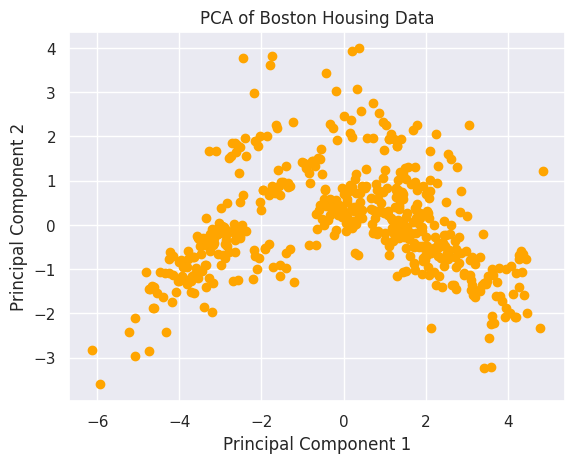

In [17]:
## TASK 7: Plot two principal components
import matplotlib.pyplot as plt

plt.scatter(pca_pd_df["PC1"], pca_pd_df["PC2"], color='orange')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Boston Housing Data")
plt.show()

In [18]:
## TASK 8: Vectorize features and target together for model development

# use the VectorAssembler to transform your DataFrame
assem_df = assembler.transform(boston_df)

# Select the relevant columns(features and target
assem_df = assem_df.select("features", "medv")

# show the resulting DataFrame
assem_df.show(10)


+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
|[0.02985,0.0,2.18...|28.7|
|[0.08829,12.5,7.8...|22.9|
|[0.14455,12.5,7.8...|27.1|
|[0.21124,12.5,7.8...|16.5|
|[0.17004,12.5,7.8...|18.9|
+--------------------+----+
only showing top 10 rows



In [21]:
## TASK 9: Split dataset into training and testing dataset
train_data, test_data = assem_df.randomSplit([0.8, 0.2], seed=1234)

In [27]:
## TASK 10: Fit model for linear regression
from pyspark.ml.regression import LinearRegression

# Specify the correct label column name
lr = LinearRegression(featuresCol="features", labelCol="medv")

# fit the model from train set
lr_model = lr.fit(train_data)

In [26]:
## TASK 11: Find out model coefficients and intercept
coeff = lr_model.coefficients
intercept = lr_model.intercept

print("Coefficients: " + str(coeff))
print("Intercept: " + str(intercept))

Coefficients: [-0.11166968641972451,0.0513387390467213,0.06157140227706896,2.1424274525657574,-22.13324118651141,3.8455255967639017,0.005097319974480969,-1.639857270571322,0.3007816839899243,-0.012078932531607512,-1.0727086557243122,0.00865614167805962,-0.5130768636704376]
Intercept: 40.828724013434496


In [25]:
## Step 12: Evaluate model for test dataset
from pyspark.ml.evaluation import RegressionEvaluator

# Assume dataset named 'test_data'
test_results = lr_model.evaluate(test_data)


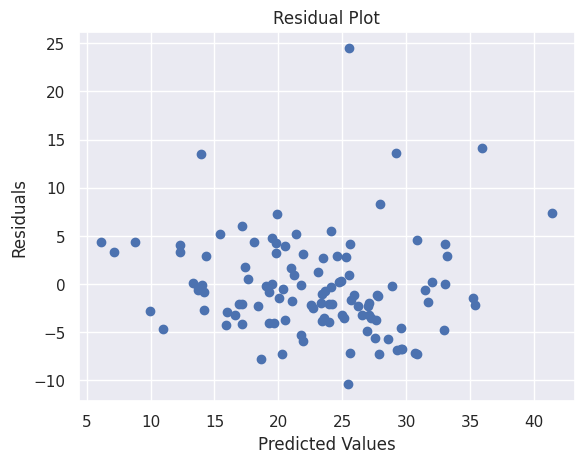

In [29]:
## Step 13: Perform further analysis for better interpretation of model results

# Assuming you have already fitted a linear regression model named 'lr_model'
# and obtained predictions on the test data as 'pred'

# Generate predictions on the test data
pred = lr_model.transform(test_data)

#Calculate residuals (difference between actual and predicted values)
# Use 'medv' instead of 'label' to calculate residuals because 'medv' is the actual label column
residuals = pred.select('medv', 'prediction').rdd.map(lambda x: x['medv'] - x['prediction']).collect()

#Evaluate the predicted values
predicted = pred.select('prediction').rdd.map(lambda x: x['prediction']).collect()

# Create a residual plot
import matplotlib.pyplot as plt # Import matplotlib for plotting
plt.scatter(predicted, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

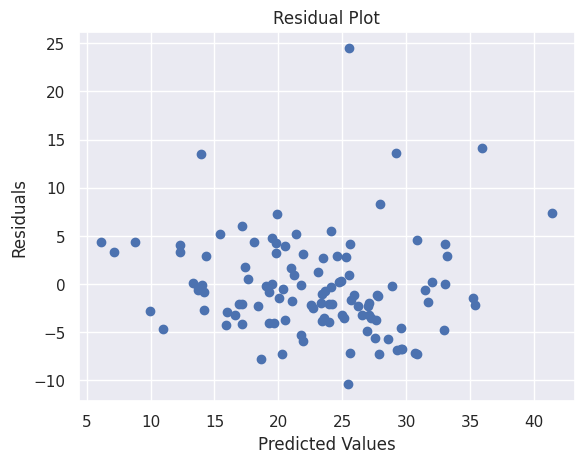

In [32]:
## Step 13: Perform further analysis for better interpretation of model results

# Assuming you have already fitted a linear regression model named 'lr_model'
# and obtained predictions on the test data as 'pred'

# Generate predictions on the test data
pred = lr_model.transform(test_data)

#Calculate residuals (difference between actual and predicted values)
# Use 'medv' instead of 'label' to calculate residuals because 'medv' is the actual label column
residuals = pred.select('medv', 'prediction').rdd.map(lambda x: x['medv'] - x['prediction']).collect()

#Evaluate the predicted values
predicted = pred.select('prediction').rdd.map(lambda x: x['prediction']).collect()

# Create a residual plot
import matplotlib.pyplot as plt # Import matplotlib for plotting
plt.scatter(predicted, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

+--------------------+----+------------------+
|            features|medv|        prediction|
+--------------------+----+------------------+
|[0.00906,90.0,2.9...|32.2|31.992892385775264|
|[0.01311,90.0,1.2...|35.4| 30.86174226047695|
|[0.02498,0.0,1.89...|16.5|21.739350064389328|
|[0.02731,0.0,7.07...|21.6|25.159805087588282|
|[0.02763,75.0,2.9...|30.8| 31.43600513469634|
+--------------------+----+------------------+
only showing top 5 rows



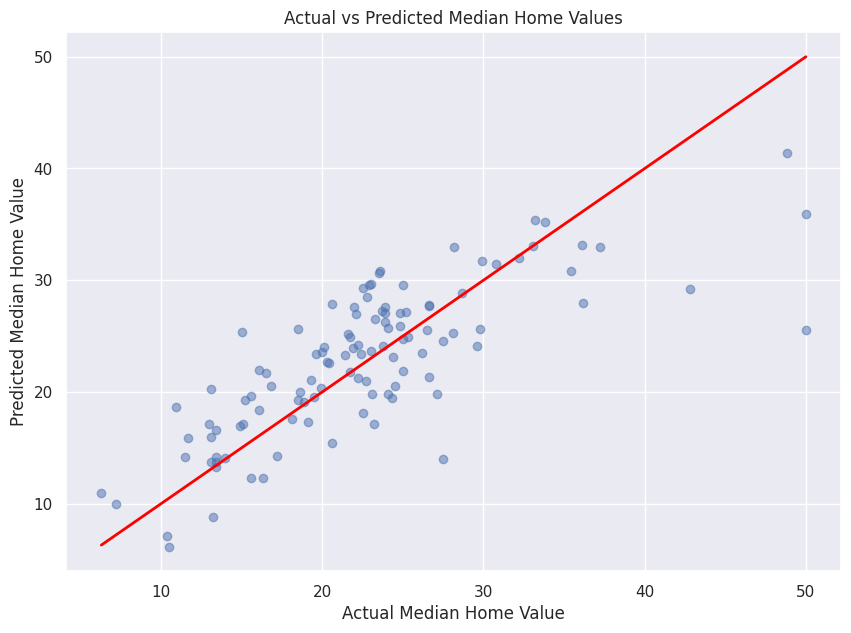

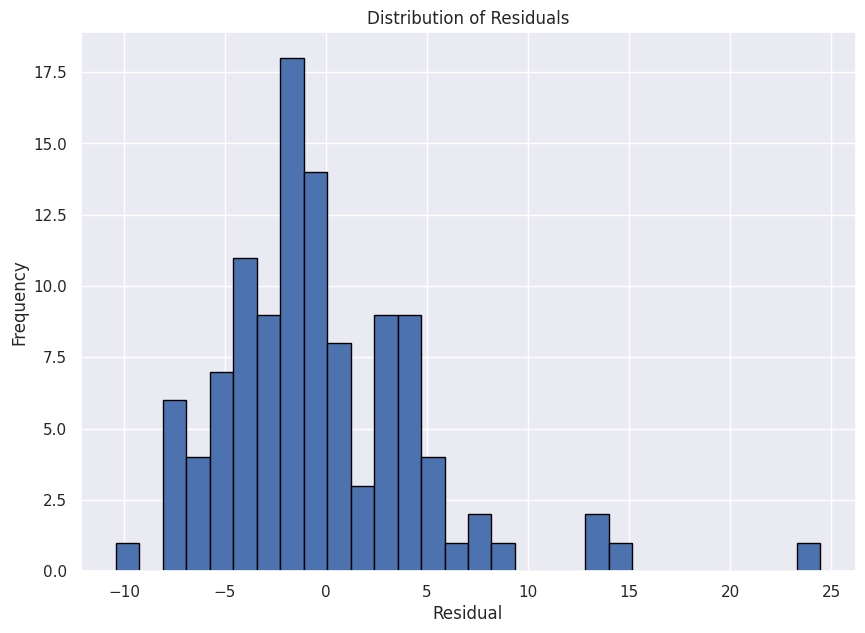

In [33]:
# Show sample predictions
pred.select("features", "medv", "prediction").show(5) # Use 'pred' instead of 'predictions'

# Residual analysis
predictions_df = pred.toPandas() # Use 'pred' instead of 'predictions'
plt.figure(figsize=(10, 7))
plt.scatter(predictions_df["medv"], predictions_df["prediction"], alpha=0.5)
plt.plot([predictions_df["medv"].min(), predictions_df["medv"].max()],
         [predictions_df["medv"].min(), predictions_df["medv"].max()],
         color='red', linewidth=2)
plt.title("Actual vs Predicted Median Home Values")
plt.xlabel("Actual Median Home Value")
plt.ylabel("Predicted Median Home Value")
plt.show()

# Distribution of residuals
residuals = predictions_df["medv"] - predictions_df["prediction"]
plt.figure(figsize=(10, 7))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

In [35]:
# Apply the Breusch-Pagan test for heteroscedasticity
from pyspark.sql.functions import col

# Calculate Residuals

# Assuming you have a trained model `lr_model` and `test_data`
predictions = lr_model.transform(test_data)
# Use 'medv' instead of 'label' to calculate residuals
predictions = predictions.withColumn("residuals", col("medv") - col("prediction"))
predictions = predictions.withColumn("squared_residuals", col("residuals")**2)
predictions.show(5)

+--------------------+----+------------------+-------------------+--------------------+
|            features|medv|        prediction|          residuals|   squared_residuals|
+--------------------+----+------------------+-------------------+--------------------+
|[0.00906,90.0,2.9...|32.2|31.992892385775264|0.20710761422473922|0.042893563869863406|
|[0.01311,90.0,1.2...|35.4| 30.86174226047695|  4.538257739523047|  20.595783310340835|
|[0.02498,0.0,1.89...|16.5|21.739350064389328| -5.239350064389328|   27.45078909721645|
|[0.02731,0.0,7.07...|21.6|25.159805087588282|-3.5598050875882805|  12.672212261619405|
|[0.02763,75.0,2.9...|30.8| 31.43600513469634|-0.6360051346963402|  0.4045025313601099|
+--------------------+----+------------------+-------------------+--------------------+
only showing top 5 rows



In [37]:
# Create an Auxiliary Regression Model
from pyspark.ml.regression import LinearRegression

# Define the auxiliary regression model
aux_lr = LinearRegression(featuresCol="features", labelCol="squared_residuals", predictionCol="aux_prediction") # Change the prediction column name

# Fit the model
aux_lr_model = aux_lr.fit(predictions)

In [38]:
# Perform the Test
# Number of observations
n = predictions.count()

# R-squared of the auxiliary regression
r_squared = aux_lr_model.summary.r2

# Breusch-Pagan test statistic
bp_statistic = n * r_squared

# p-value for the test statistic
from scipy.stats import chi2

p_value = chi2.sf(bp_statistic, df=aux_lr_model.numFeatures)

print(f"Breusch-Pagan Test Statistic: {bp_statistic}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: Heteroscedasticity is present.")
else:
    print("Fail to reject the null hypothesis: No evidence of heteroscedasticity.")


Breusch-Pagan Test Statistic: 24.82511538794931
p-value: 0.024335378291668187
Reject the null hypothesis: Heteroscedasticity is present.
